##### The goal of the second part of the project is to Build an Image Classification Model that classifies the image into one of the 5 classes (0,1,2,3,4). This Image Classification Model can accelerate the process of Blindness Detection in Patients. Currently Doctors review the Image and classify it into one of the classes - 

* 0 - No Diabetic Retinopathy
* 1 - Mild
* 2 - Moderate
* 3 - Severe
* 4 - Proliferative Diabetic Retinopathy

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
import os
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [2]:
labels = pd.read_csv('DATASET/train.csv')
dir_ = os.path.join('DATASET/images/') 
labels['file_path'] = labels['id_code'].map(lambda x:os.path.join(dir_,'{}.png'.format(x)))
labels['file_name'] = labels['id_code'].apply(lambda x: x + ".png")
labels['diagnosis'] = labels['diagnosis'].astype(str)

In [3]:
labels.head()

,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,DATASET/images/000c1434d8d7.png,000c1434d8d7.png
1,001639a390f0,4,DATASET/images/001639a390f0.png,001639a390f0.png
2,0024cdab0c1e,1,DATASET/images/0024cdab0c1e.png,0024cdab0c1e.png
3,002c21358ce6,0,DATASET/images/002c21358ce6.png,002c21358ce6.png
4,005b95c28852,0,DATASET/images/005b95c28852.png,005b95c28852.png


In [4]:
#Bar plot of Classes Distribution
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show() 

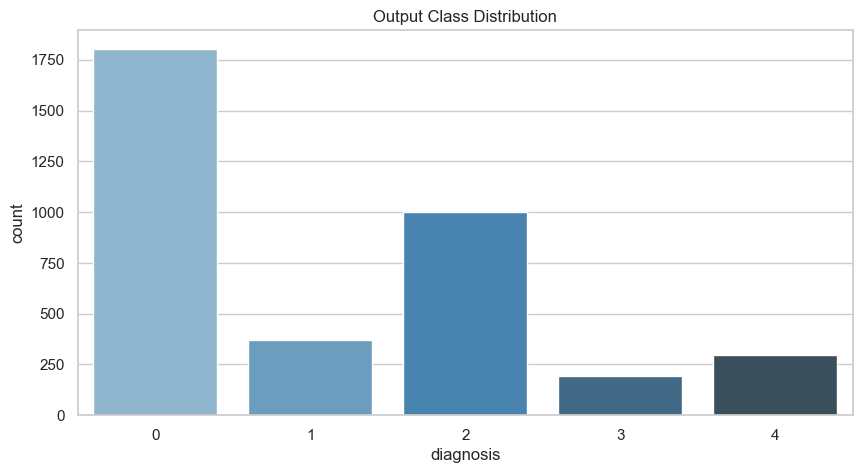

In [5]:
plot_classes(labels)

* As we can see, there is class imbalance in the output class distribution. We shall account for this while training the models using data augmentation / class balancing methods

In [6]:
#Declared global variable with assumed size to reduce computational complexity
IMG_SIZE = 320

In [7]:
#Converts a color image to gray scale image
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img

In [8]:
#This Function shows the visual Image photo of '1 x 5' points (5 of each class)
def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))
        plt.show()

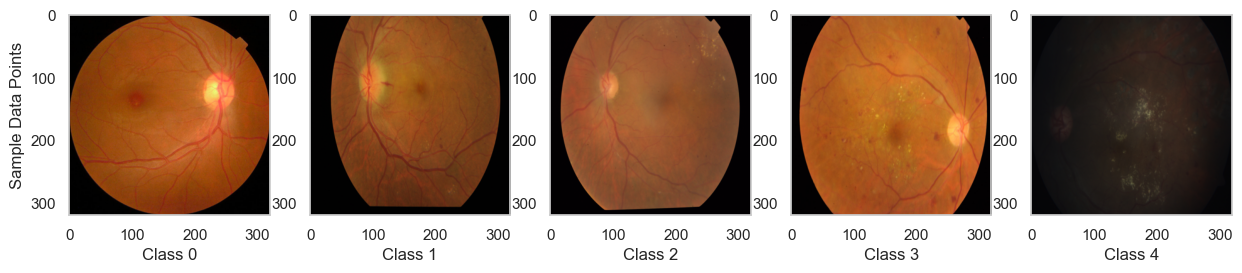

In [9]:
visualize_imgs(labels,1,color_scale = None)

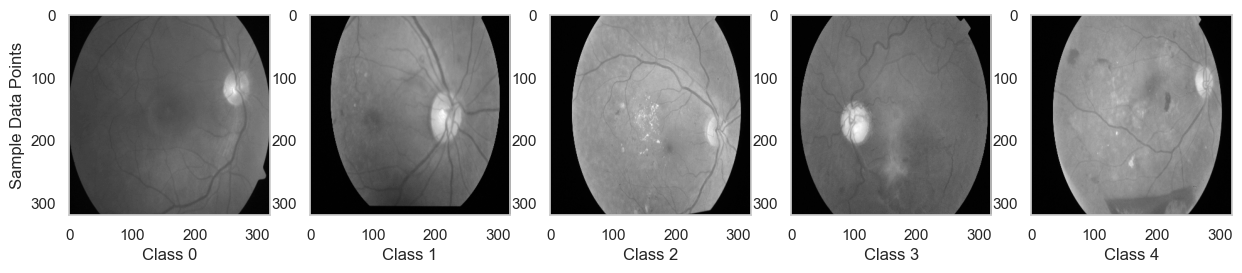

In [10]:
visualize_imgs(labels,1,color_scale = 'gray')

* We can see, as we move towards higher classes, we are able to comprehend larger number of abnormalities in the eye images. Also, the lightning and brightness conditions are not even across all images. We will try to handle this using image processing techniques. Also, Gray Scale Images are giving better visualization of the eye features as compared to RGB images

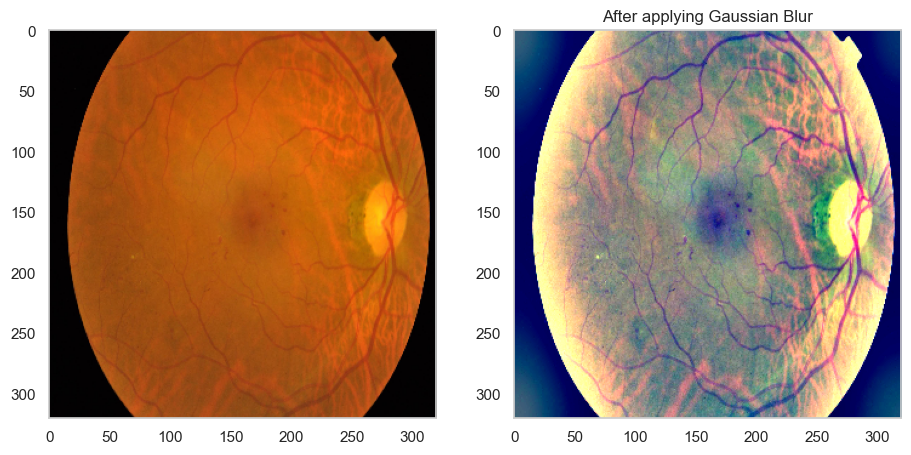

In [11]:
# Applying Gaussian Blur on top of our images
rn = np.random.randint(low = 0,high = len(labels) - 1)
img = cv2.imread(labels.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)
f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

* We can see that after applying Gaussian Blur, We are able to bring out the features/image details much more clearer in the eye.

In [12]:
#Preprocessing images by performing Gaussian Blur and Circle Crop
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # if image is too dark, we crop out everything
            return img # returns original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
#Create circular crop around image centre    
def circle_crop(img, sigmaX):   
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

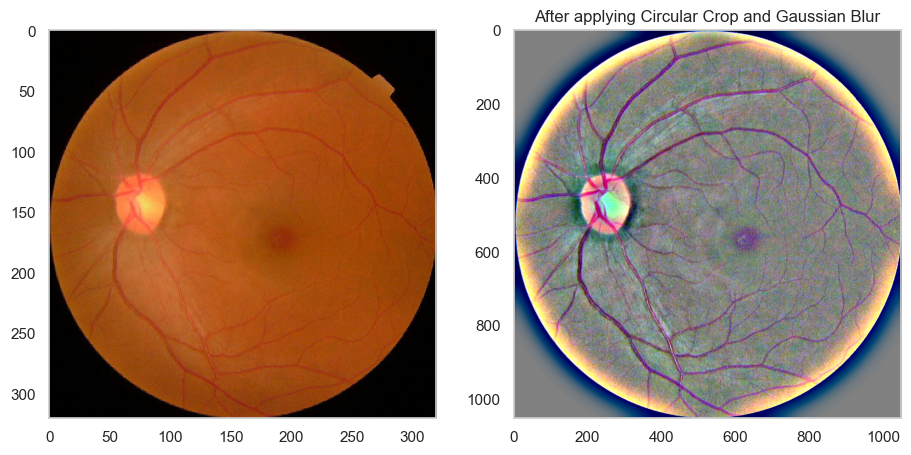

In [13]:
#Perform Image Processing on a sample image
rn = np.random.randint(low = 0,high = len(labels) - 1)
img = cv2.imread(labels.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)
f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

* We can observe that now the image features and details are very much clearer than what the image was before, we are ready to use this image for modelling as the image details are much more clearer

In [14]:
#This Function shows the visual Image photo of 'n x 5' points and performs image processing (Gaussian Blur, Circular crop) transformation.

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

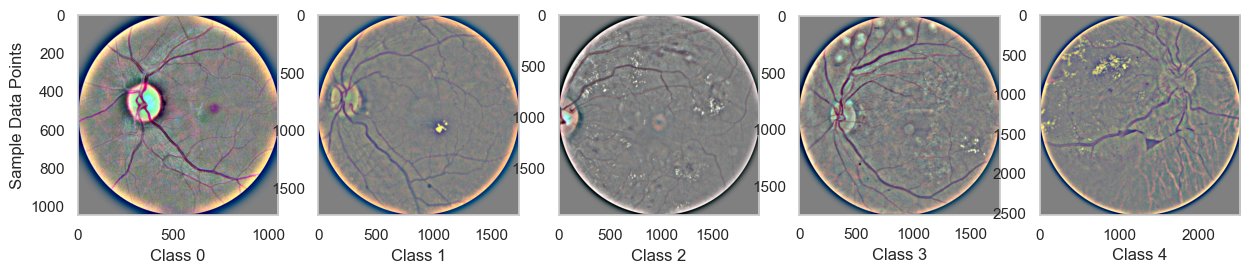

In [15]:
visualize_img_process(labels,1,sigmaX = 30)

* Clearly we understand the importance of performing image processing operations here. We have performed Gaussian Blur to bring out the image details and features much more clearly and explicitly. 

In [16]:
def generate_augmentations(lim):
    fig, axs = plt.subplots(1, min(lim + 10, 5), figsize=(30, 40))
    datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        horizontal_flip=True
    )
    img = cv2.imread(labels.file_path.iloc[np.random.randint(low=0, high=len(labels) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    axs[0].imshow(img)
    axs[0].set_title('ORIGINAL IMAGE')

    img_arr = img.reshape((1,) + img.shape)

    for i, img_iterator in enumerate(datagen.flow(x=img_arr, batch_size=1)):
        if i >= lim or i >= 4:
            break
        axs[i + 1].imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        axs[i + 1].set_title('IMAGE AUGMENTATION ' + str(i + 1))

    plt.tight_layout()
    plt.show()


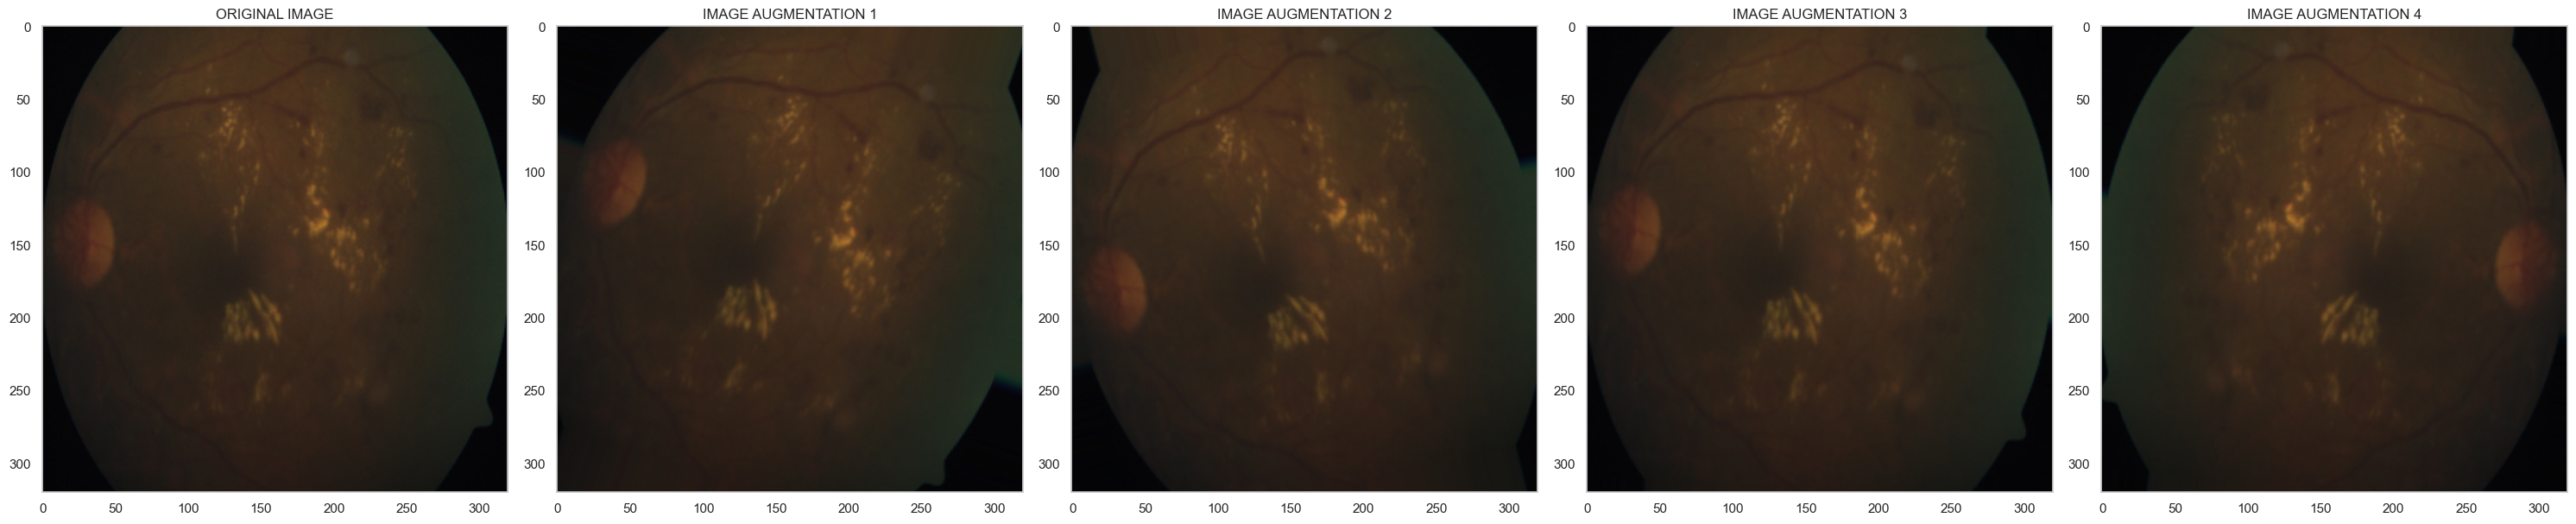

In [17]:
generate_augmentations(4)

* Image Augmentations are extremely helpful for this dataset to make our Models more Robust and would also have a higher ability to generalize well